In [1]:
import sklearn
import pandas as pd
from random import randint
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer
import json
import numpy as np
data_dir = '/home/luke/fun_code/tennis/tennis_wta/'

In [2]:
data = {}
player_data = {}
tracked_stats = ['id','hand','ht','rank'] 
for year in range(2005,2025):
    current_year = pd.read_csv(data_dir + f'wta_matches_{year}.csv', usecols=['surface','tourney_level','winner_name','loser_name','winner_id', 'loser_id', 'winner_rank', 'loser_rank', 'best_of','winner_hand','loser_hand','winner_ht','loser_ht'])
    current_year = current_year.drop(current_year[current_year['surface'] == 'Carpet'].index)
    for i in current_year.iterrows():
        for j in current_year.columns:
            if pd.isnull(i[1][j]):
                if j == 'winner_rank' or j == 'loser_rank':
                    continue
                else:
                    data_year = current_year.drop(i[0])
    data_year['surface'] = data_year['surface'].map({'Hard':2,'Clay':3,'Grass':1})
    data_year['tourney_level'] = data_year['tourney_level'].map({'G':1,'F':2,'O':2,'PM':3,'P':4,'I':5,'T1':3,'T2':4,'T3':5,'T4':5,'T5':5,'D':6})

    for wl in ['winner','loser']:
        data_year[f'{wl}_hand'] = data_year[f'{wl}_hand'].map({'R':1,'L':2,'U':3})
    data[year] = data_year
    data[year]['year'] = year
    player = {1:{},2:{}}
    for stat in tracked_stats:
        player[1][stat] = []
        player[2][stat] = []
    winner_number = []
    for i in data[year].iterrows():
        for player_lw in ['winner', 'loser']:
            if i[1][f'{player_lw}_name'] not in player_data.keys():
                player_data[i[1][f'{player_lw}_name']] = {}
                for stat in tracked_stats[:-1]:
                    player_data[i[1][f'{player_lw}_name']][stat] = i[1][f'{player_lw}_{stat}']

            if i[1][f'{player_lw}_id'] not in player_data.keys():
                player_data[i[1][f'{player_lw}_id']] = i[1][f'{player_lw}_name']

        flip = randint(1,2)
        winlossno = {}
        if flip == 1:
            winlossno['winner'] = 1
            winlossno['loser'] = 2
        elif flip == 2:
            winlossno['winner'] = 2
            winlossno['loser'] = 1
        for player_lw in ['winner', 'loser']:
            for stat in tracked_stats:
                player[winlossno[player_lw]][stat].append(i[1][f'{player_lw}_{stat}'])
        winner_number.append(flip)
    for stat in tracked_stats:
        data[year][f'player_1_{stat}'] = player[1][stat]
        data[year][f'player_2_{stat}'] = player[2][stat]
    data[year]['winner'] = winner_number
    for stat in tracked_stats:
        data[year].drop(labels=f'loser_{stat}', axis=1, inplace=True)
        data[year].drop(labels=f'winner_{stat}', axis=1, inplace=True)
    for wl in ['winner','loser']:
        data[year].drop(labels=f'{wl}_name', axis=1, inplace=True)


In [3]:
df = pd.concat([data[i] for i in data], ignore_index=True)

df.fillna(3000, inplace=True)
df['winner'] = df['winner'].map({1.0:1.0,2.0:0.0})

json_object = json.dumps(player_data, indent=4)
df.to_csv('tennis.csv', index=False)
 
# Writing to sample.json
with open("players.json", "w") as outfile:
    outfile.write(json_object)
df.head()

,surface,tourney_level,best_of,year,player_1_id,player_2_id,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_rank,player_2_rank,winner
0,3.0,6.0,3,2005,201423,201527,1.0,1.0,175.0,170.0,135.0,1024.0,1.0
1,3.0,6.0,3,2005,201481,201490,1.0,1.0,165.0,170.0,3000.0,280.0,1.0
2,3.0,6.0,3,2005,201490,201423,1.0,1.0,170.0,175.0,280.0,135.0,1.0
3,3.0,6.0,3,2005,201335,201481,1.0,1.0,172.0,165.0,3000.0,3000.0,0.0
4,2.0,6.0,3,2005,200055,200079,1.0,1.0,172.0,175.0,71.0,14.0,0.0


In [4]:
features=["surface","tourney_level","player_1_hand","player_2_hand","player_1_ht","player_2_ht","player_1_rank","player_2_rank","winner"]
df=df[features]
df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('winner', axis=1)
X_valid = df_valid.drop('winner', axis=1)
y_train = df_train['winner']
y_valid = df_valid['winner']
X_train.shape[1]

8

/home/luke/miniconda3/envs/ml/lib/python3.13/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.5821 - loss: 1.2507 - val_binary_accuracy: 0.6393 - val_loss: 0.6940
Epoch 2/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.6429 - loss: 0.6586 - val_binary_accuracy: 0.6269 - val_loss: 0.6521
Epoch 3/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.6344 - loss: 0.6539 - val_binary_accuracy: 0.6311 - val_loss: 0.6508
Epoch 4/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.6450 - loss: 0.6351 - val_binary_accuracy: 0.6520 - val_loss: 0.6300
Epoch 5/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.6476 - loss: 0.6327 - val_binary_accuracy: 0.6453 - val_loss: 0.6415
Epoch 6/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.6488 - loss: 0.6291 - val_binary_accuracy: 0.6460 - val_loss: 0.6274
Epoch 7/1000
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - binary_accuracy: 0.6505 - loss: 0.6268 - val_binary_accuracy: 0.6425 - val_loss: 0.6283

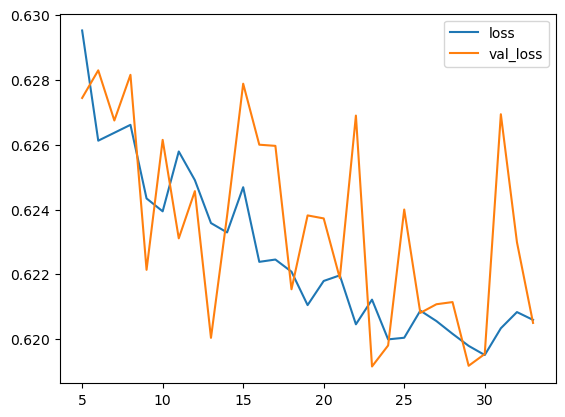

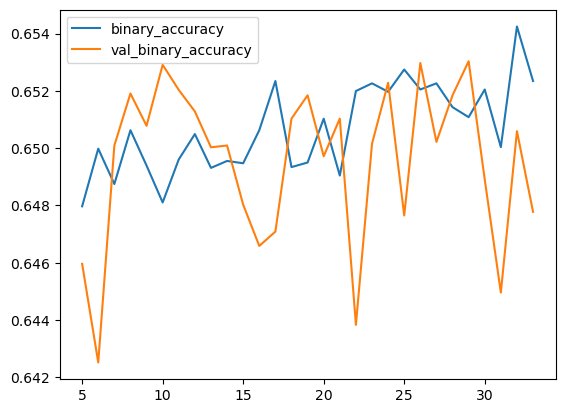

In [5]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import keras
from keras import layers
import torch
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),  
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),  
    layers.Dense(256, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping]
     # hide the output because we have so many epochs
)

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))